<a href="https://colab.research.google.com/github/swishswish123/endosim_demo/blob/main/notebooks/endoscope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!git clone https://github.com/swishswish123/endosim_demo.git

fatal: destination path 'endosim_demo' already exists and is not an empty directory.


In [103]:
!pip install scikit-surgeryvtk

# Tracked Endoscope

This notebook explores the accuracy of AR using tracked endoscope.


In [104]:

import copy
import numpy as np
import cv2
import random
from scipy.spatial.transform import Rotation as spr
from matplotlib import pyplot as plt
import sksurgerycore.algorithms.procrustes as pro
import sksurgerycore.transforms.matrix as mu
from IPython.display import Image
import csv

## Utility functions and imports


In [105]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print(f'added {module_path} to sys')
    sys.path.append(module_path)

In [106]:
from endosim_demo.end_utils import create_transform, \
                                  multiply_points_by_matrix, \
                                  multiply_point_by_matrix, pointer_to_mri,\
                                  camera_to_mri, mri_to_camera, add_noise_to_points,\
                                  add_noise_to_params, extract_rigid_body_parameters,\
                                  rigid_body_parameters_to_matrix, \
                                  convert_4x1_to_1x1x3, project_camera_point_to_image, \
                                  create_pnt_ref, create_pnt_ref_in_camera_space, create_pat_ref, \
                                  create_pat_ref_in_camera_space, get_ref_T_tip, calculate_euclid_dist



## System layout

In the pointer notebook, we studied the accuracy of measuring a point in 3D space, using a tracked pointer, and converting that to a point in the MR/CT scan, via registration.

In this notebook we want to study the accuracy of a tracked endoscope, and what the expected accuracy of an overlay will be. The overlay accuracy, could be measured in terms of accuracy in 3D in the endoscope camera frame, or in terms of 2D pixel accuracy.

In order to make this a like-for-like comparison, we should keep most of the reference data identical. The difference now, is we swap a pointer for an endoscope. We will need an additional hand-eye calibration, and reference data to project from camera space onto image space, but we leave all other data the same. 

The following diagram shows the layout of the navigation system.



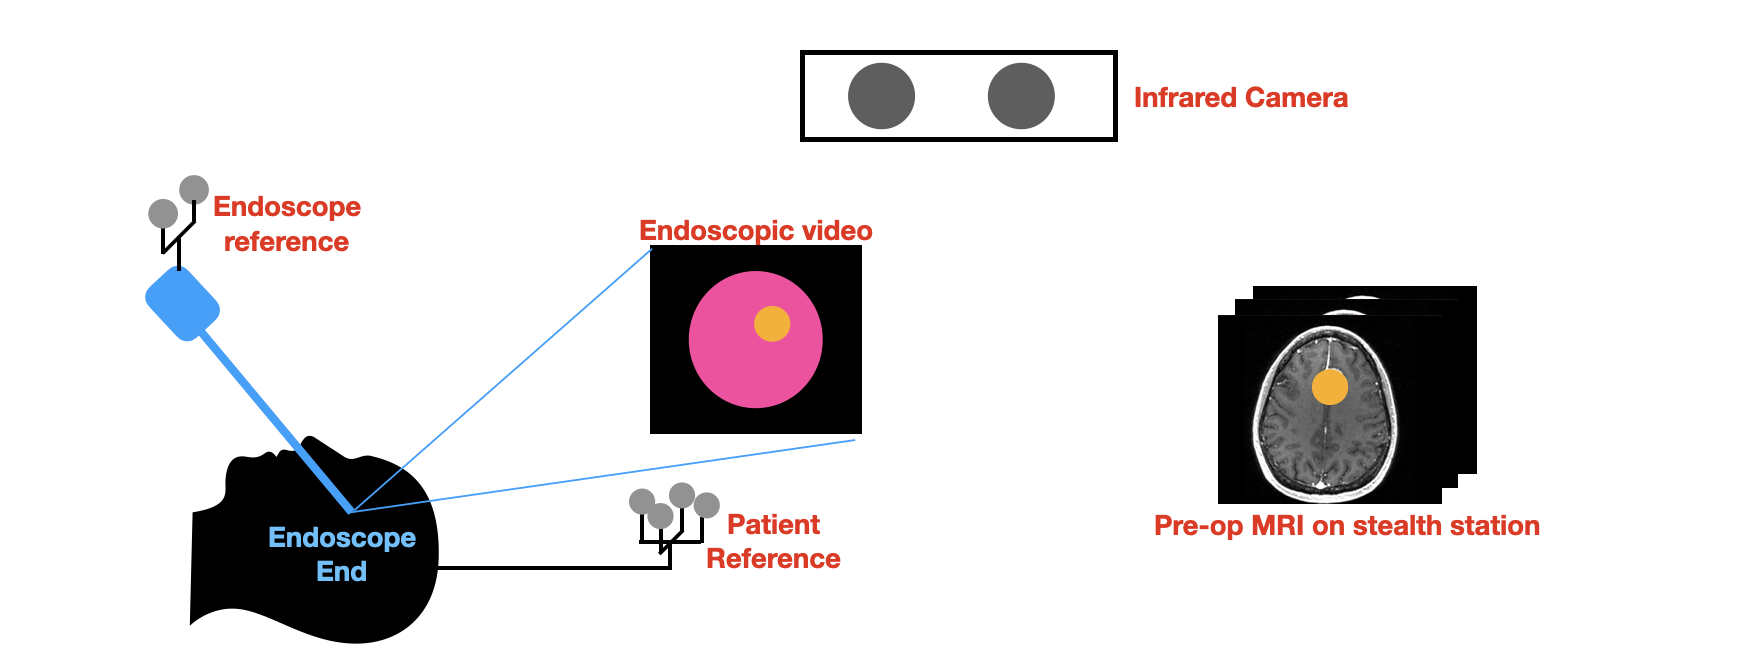

In [107]:
Image(filename="endosim_demo/images/endoscope_setup.png")

In the above image, we can see the general setup involved in the surgery when using a pointer. The goal is to be able to display some segmented piece of information from the pre-operative MRI in MRI coordinates onto the endoscopic video:


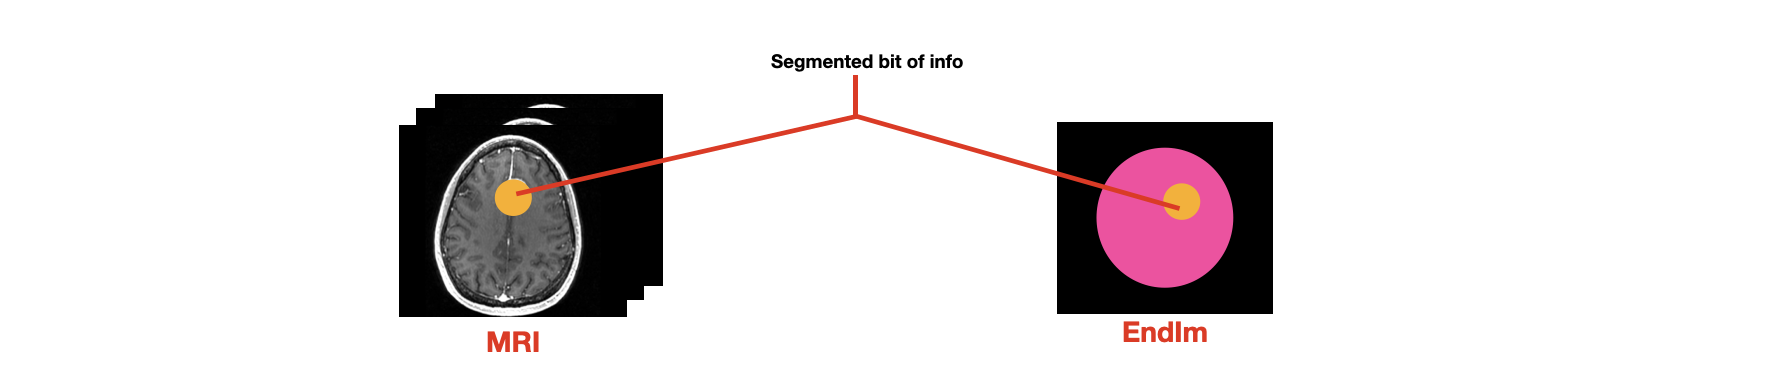

In [108]:
Image(filename="endosim_demo/images/endoscope_goal.png")

The goal is therefore turning some segmented MRI coordinates to Endoscopic Image (EndIm) coordinates.

X<sub>EndIm</sub> = T X<sub>MRI</sub>

where T is composed of the following transforms:

T = <sup>EndIm</sup>T<sub>EndP</sub> * 
    <sup>EndP</sup>T<sub>EndRef</sub> * 
    <sup>EndRef</sup>T<sub>Cam</sub>  * 
    <sup>Cam</sup>T<sub>PatRef</sub> * 
    <sup>PatRef</sup>T<sub>MRI</sub>
    
In the following sections we will go step by step on how to go from each of these transforms


Here is an visual representation of the endoscope setup with all the transforms:

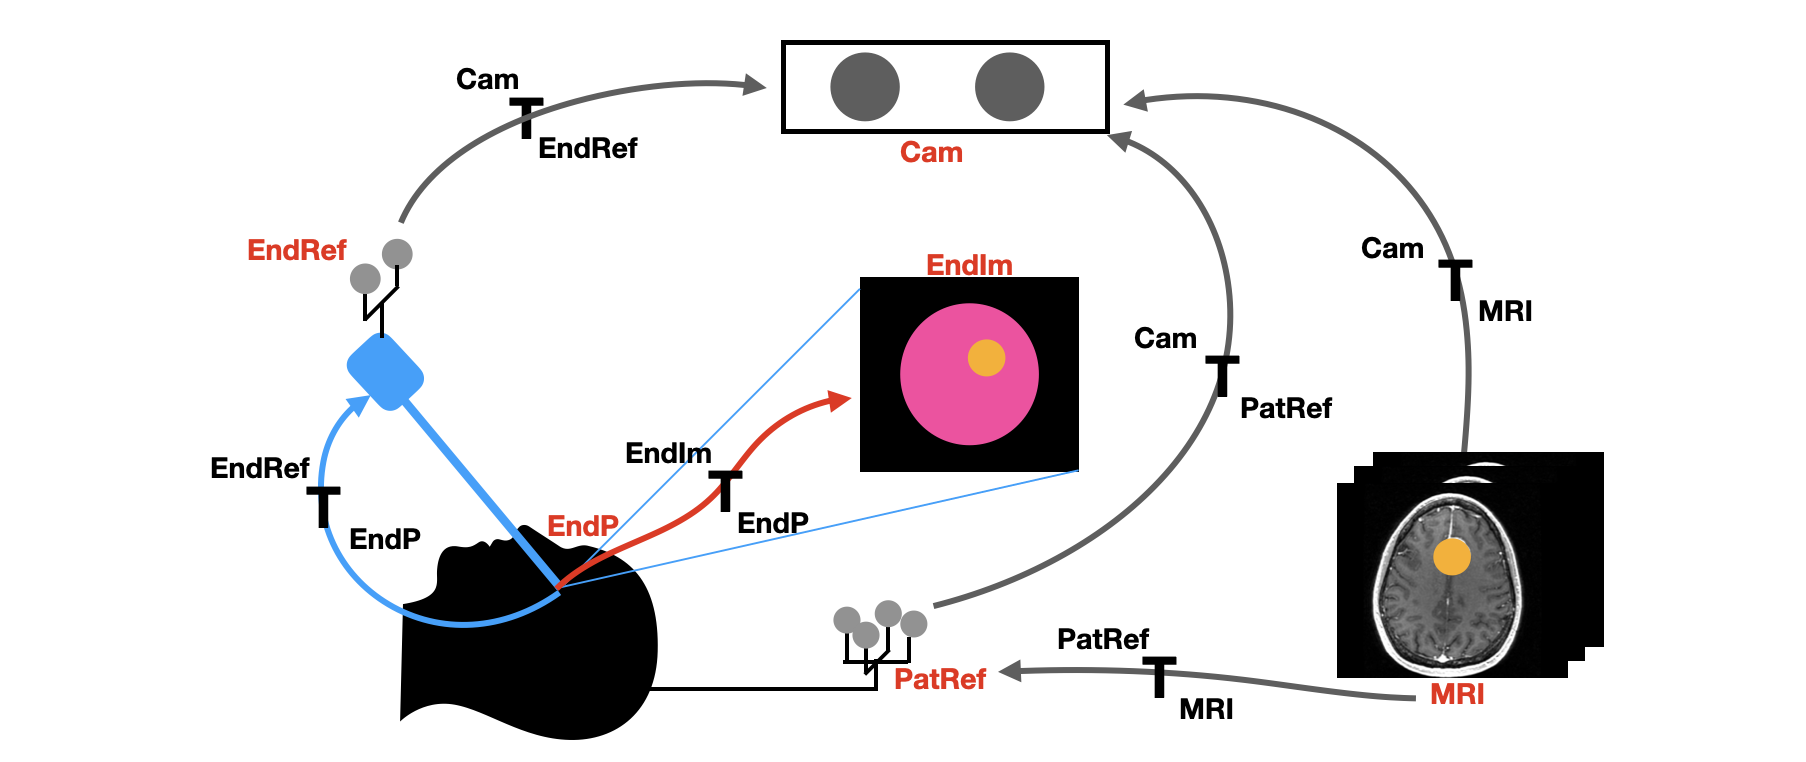

In [109]:
Image(filename="endosim_demo/images/endoscope_setup_transforms.png")

# Assumptions

Same assumptions as Pointer setup, just with endoscope replacing pointer:

1. tumour, patient reference, endoscope reference are all aligned in z direction (have same z coordinate) and are facing the camera straight on so that the distance is D

2. Patient reference is at a set distance Yc from the tumour but aligned in the X direction

3. Endoscope is touching the tumour, so the pointer and tumour have the same coordinates

4. Length of endoscope P is known

5. Angle of endoscope θ is known

Below are visual representations of the sagittal and transverse views with all assumptions

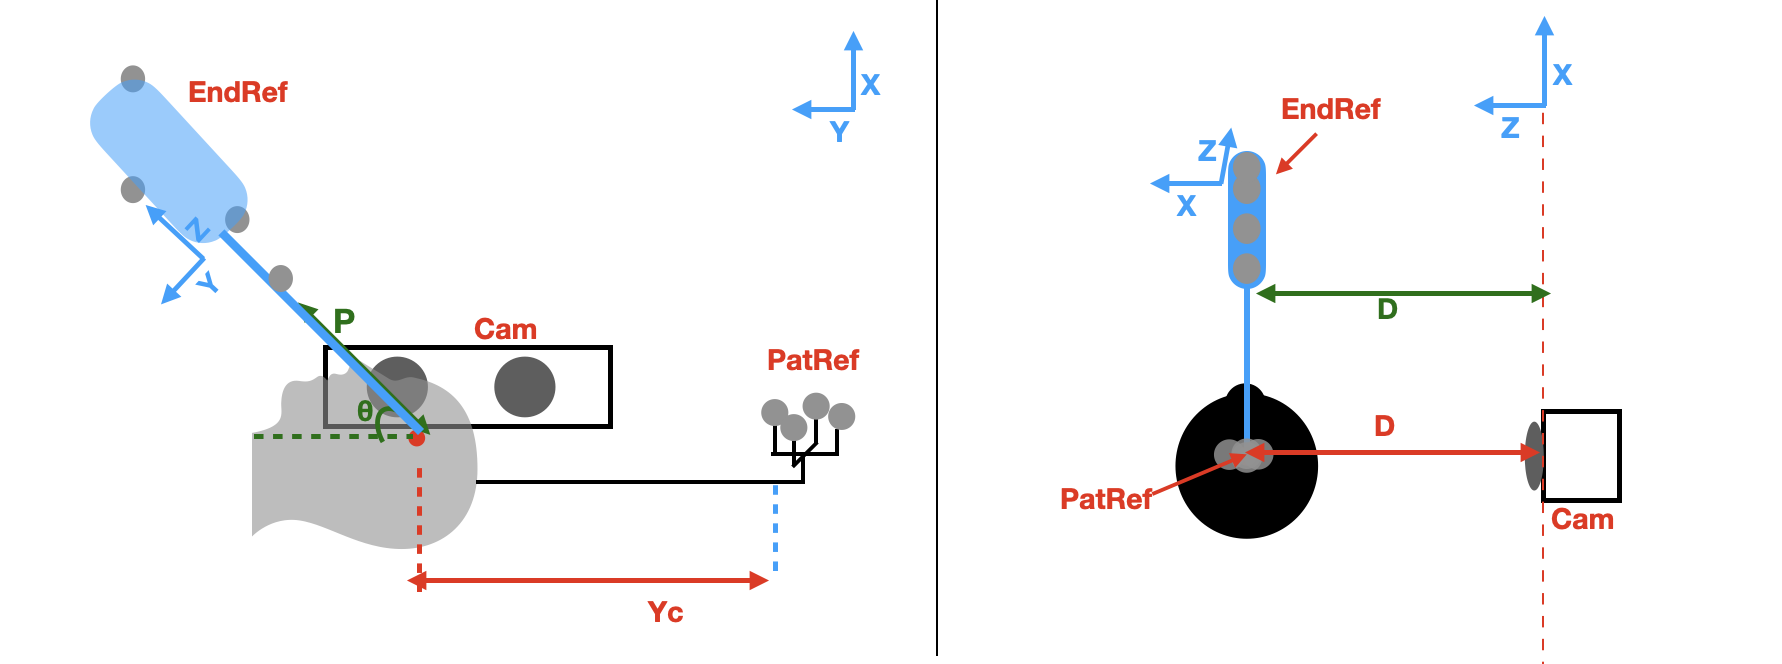

In [110]:
Image(filename="endosim_demo/images/endoscope_setup_assumptions.png")

## Configurable parameters

In [111]:
# ALL MEASUREMENTS IN MM

# P - , the length of the endoscope.
length_of_endoscope = 150 # use 300 after merging

# D - z distance from camera to plane where everything is located
distance_from_cam = 1000 # since the camera and patient reference are aligned in the x and y directions, only distance is in z

# 0 - angle of pointer
pointer_angle = 45

# Yc - distances from tumour to patient reference
tumour_patref_y = 50  

# NDI quotes 0.25mm for Polaris Spectra, some papers estimate it at 0.17mm
typical_tracking_sigma = 0.25

# For Model 2 and 3, using an endoscope, this determines the distance of a target of interest from the endoscope.
working_distance = 50

# for simulation to be reproducible
number_samples = 10



## Creating the reference data for the Endoscope, in endoscope coordinates.

Here is an image of the endoscope's reference geometry (we use the same as the pointer so that they are easily comparable):



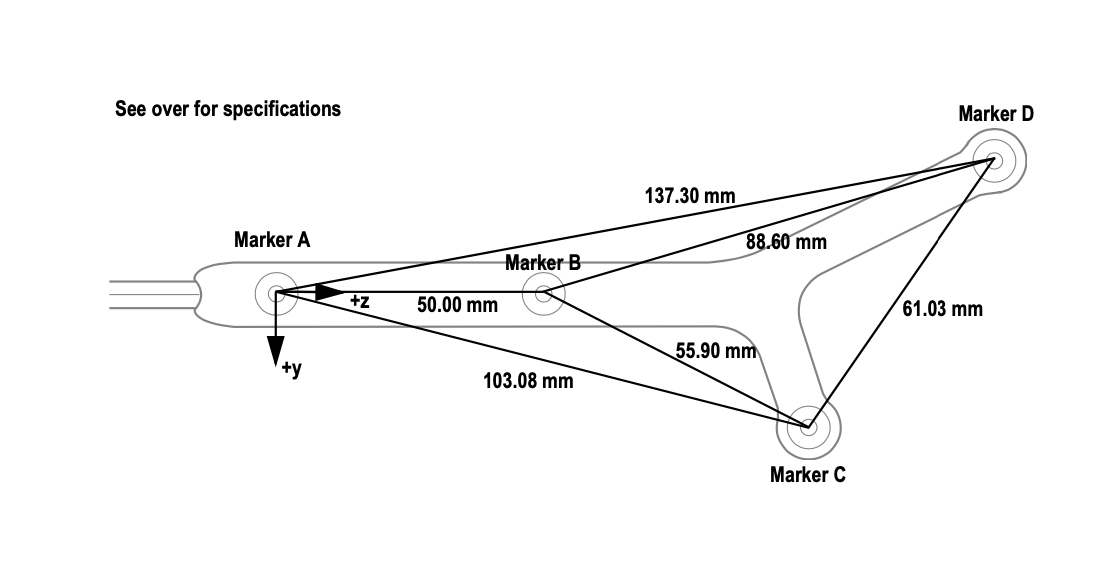

In [112]:
Image(filename="endosim_demo/images/pointer_geometry.png")

In our case, let us assume we already know what the length of the endoscope is.

In [113]:
print(f'endoscope length is: {length_of_endoscope}mm' )

endoscope length is: 150mm


Creating reference points of endoscope:

[[  0.   0.   0.   1.]
 [  0.   0.  50.   1.]
 [  0.  25. 100.   1.]
 [  0. -25. 135.   1.]]


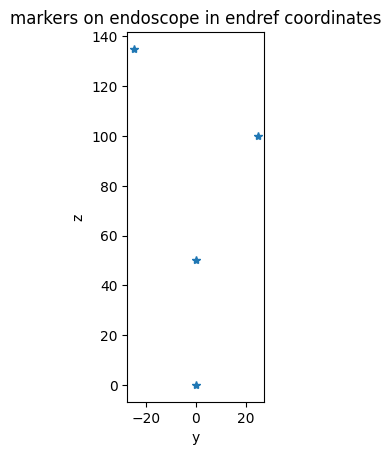

In [114]:
 # Creating pointer reference (from datasheet). Using homogenous (4 numbers, x,y,z,1) as row vectors.
end_ref =  create_pnt_ref()
print(end_ref)

# Plotting original points, to check it looks ok.
plt.figure()
plt.plot(end_ref[:,1],end_ref[:,2], marker='*',linestyle = 'None',)
plt.title('markers on endoscope in endref coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## EndP to EndRef

We start by getting the transform between the endoscope's tip to the reference.

Converting reference points to coordinate system where the origin is at the end of the endoscope instead of at marker A.

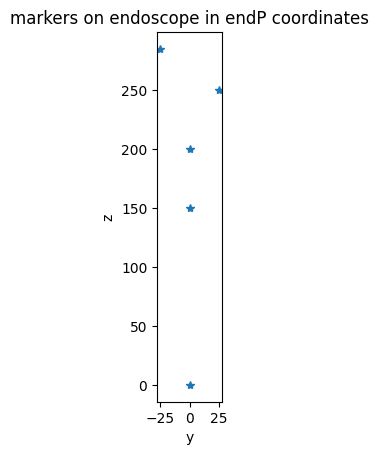

In [115]:
# Here we offset the points by the length of the pointer to make the origin the endoscope's tip
offset_marker_transform = get_ref_T_tip(length_of_endoscope, 'z') # create transform of all points depending on pointer's length
end_ref_transformed = multiply_points_by_matrix(offset_marker_transform, end_ref, do_transpose=True) # transform all pointer points by this reference
end_ref_with_tip = np.concatenate((end_ref_transformed, [[0, 0, 0, 1]]), axis=0) # adding tip to points

# Plotting transformed points
plt.figure()
plt.plot(end_ref_with_tip[:,1],end_ref_with_tip[:,2], marker='*',linestyle = 'None',)
plt.title('markers on endoscope in endP coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## EndRef to Cam

end_ref_in_camera_space_at_patient=
[[ 106.06601718  106.06601718 1000.            1.        ]
 [ 141.42135624  141.42135624 1000.            1.        ]
 [ 159.09902577  194.45436483 1000.            1.        ]
 [ 219.20310217  183.84776311 1000.            1.        ]
 [   0.            0.         1000.            1.        ]]


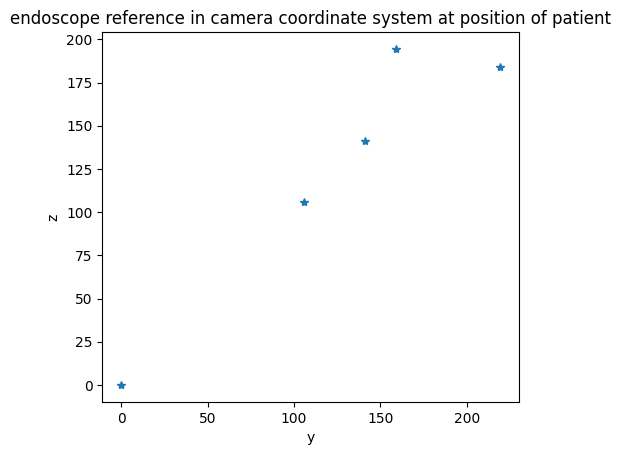

In [116]:
# endoscope reference in cam coords
end_ref_in_camera_space =  create_pnt_ref_in_camera_space()

# once again creating offset to all the points to move origin to the endoscope's tip
offset_marker_transform_cam = create_transform([length_of_endoscope, 0, 0, 0, 0, 0])
end_ref_in_camera_space_transformed = multiply_points_by_matrix(offset_marker_transform_cam, end_ref_in_camera_space, do_transpose=True)
end_ref_in_camera_space_with_tip = np.concatenate((end_ref_in_camera_space_transformed, [[0, 0, 0, 1]]), axis=0)

# Now we want to rotate around z (according to diagram above), then translate to a distance from camera.
rotate_about_z = create_transform([0, 0, 0, 0, 0, pointer_angle]) 
translate_away_from_camera = create_transform([0, 0, distance_from_cam, 0, 0, 0])
end_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_away_from_camera @ rotate_about_z, end_ref_in_camera_space_with_tip, do_transpose=True)
print("end_ref_in_camera_space_at_patient=\n" + str(end_ref_in_camera_space_at_patient))

# Plotting transformed points
plt.figure()
plt.plot(end_ref_in_camera_space_at_patient[:,0],end_ref_in_camera_space_at_patient[:,1], marker='*',linestyle = 'None',)
plt.title('endoscope reference in camera coordinate system at position of patient')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [117]:
endoscope_markers_in_camera_space = end_ref_in_camera_space_at_patient[0:4,0:3]
########## NOTE- IS THIS CORRECT? WOUDN'T IT JUST BE end_Ref? If it's in marker space the 0,0 should be in marker A?
endoscope_markers_in_marker_space = end_ref_with_tip[0:4,0:3]

print("endoscope_markers_in_camera_space=\n" + str(endoscope_markers_in_camera_space))
print("endoscope_markers_in_marker_space=\n" + str(endoscope_markers_in_marker_space))


endoscope_markers_in_camera_space=
[[ 106.06601718  106.06601718 1000.        ]
 [ 141.42135624  141.42135624 1000.        ]
 [ 159.09902577  194.45436483 1000.        ]
 [ 219.20310217  183.84776311 1000.        ]]
endoscope_markers_in_marker_space=
[[  0.   0. 150.]
 [  0.   0. 200.]
 [  0.  25. 250.]
 [  0. -25. 285.]]


Calculating transform between endoscope's marker space to camera space

In [118]:
# getting transformation between coordinate systems
Cam_T_EndRef_r, Cam_T_EndRef_t, Cam_T_Endo_FRE = pro.orthogonal_procrustes(endoscope_markers_in_camera_space, endoscope_markers_in_marker_space)
print("Cam_T_EndRef_r=\n" + str(Cam_T_EndRef_r))
print("Cam_T_EndRef_t=\n" + str(Cam_T_EndRef_t))
print("Cam_T_Endo_FRE=\n" + str(Cam_T_Endo_FRE))
# reconstructing translation and rotation to one matrix
Cam_T_EndRef = mu.construct_rigid_transformation(Cam_T_EndRef_r, Cam_T_EndRef_t)
print("Cam_T_EndRef=\n" + str(Cam_T_EndRef))



Cam_T_EndRef_r=
[[ 8.49167095e-16 -7.07106781e-01  7.07106781e-01]
 [-1.02657308e-15  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00 -1.32504145e-15 -1.91457875e-18]]
Cam_T_EndRef_t=
[[-5.68434189e-14]
 [ 2.84217094e-14]
 [ 1.00000000e+03]]
Cam_T_Endo_FRE=
3.6230712748823524e-14
Cam_T_EndRef=
[[ 8.49167095e-16 -7.07106781e-01  7.07106781e-01 -5.68434189e-14]
 [-1.02657308e-15  7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.00000000e+00 -1.32504145e-15 -1.91457875e-18  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Patient reference tracking (PatRef to Cam)

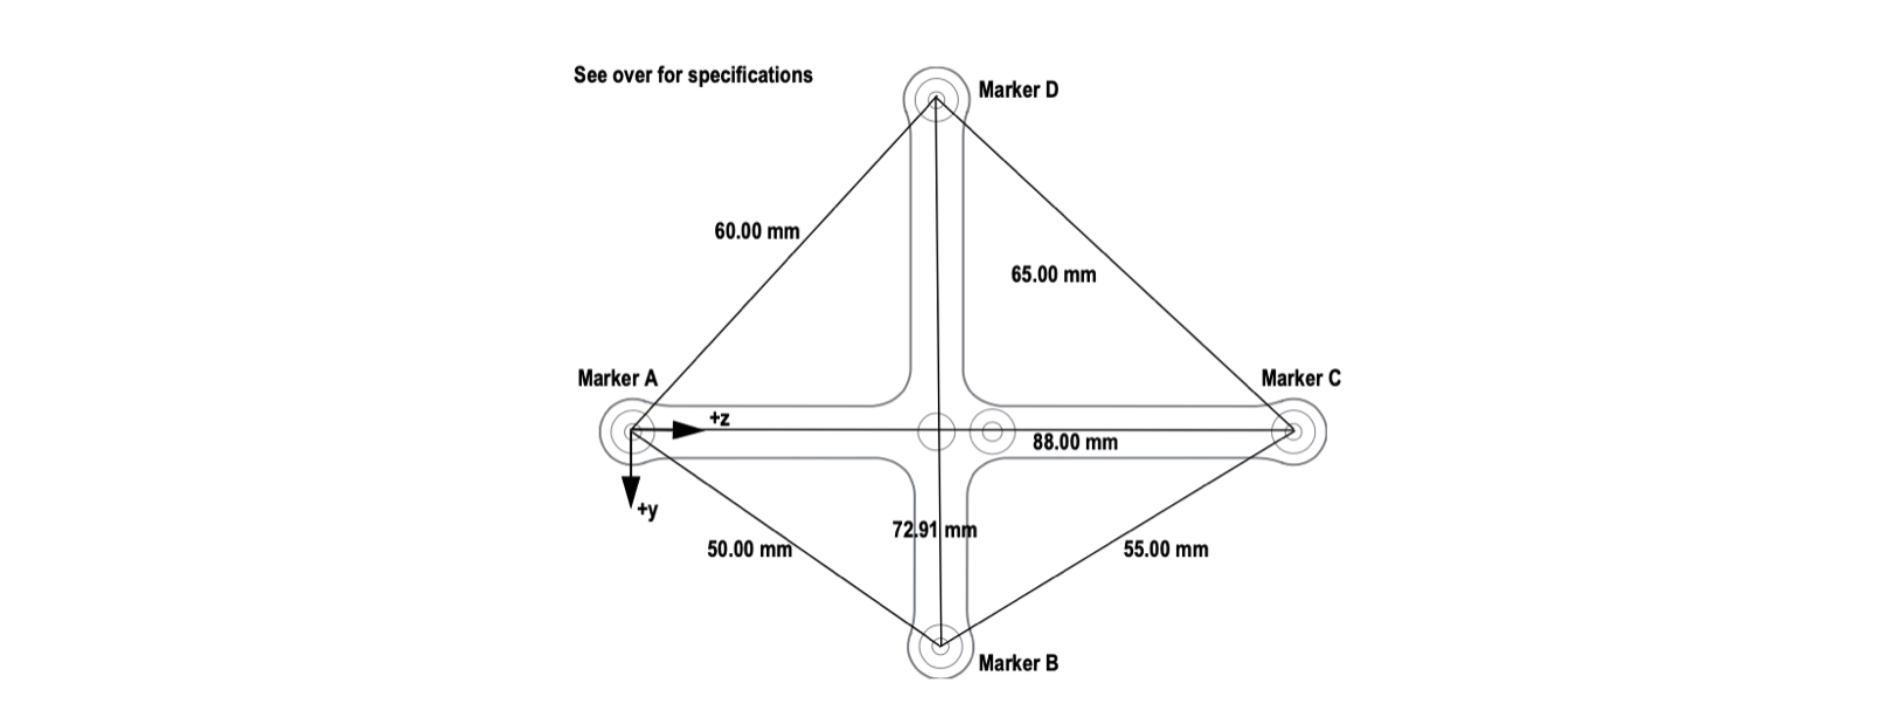

In [119]:
Image(filename="endosim_demo/images/pointer_patref_marker.png")

In [120]:
# Defining reference coordibates in ref coords (from datasheet)
#A: x=0.00, y= 0.00, z=0.00 
#B: x=0.00, y= 28.59, z=41.02 
#C: x=0.00, y= 00.00, z=88.00 
#D: x=0.00, y=-44.32, z=40.45
    
# Encoding the reference marker points into a numpy matrix
pat_ref = create_pat_ref()
print(pat_ref)

[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]


### Creating the reference data for the patient reference in camera space.

In [121]:
pat_ref_in_camera_space = create_pat_ref_in_camera_space()

# Now put it in the right place (away from patient as in pointer simulation)
translate_along_negative_y = create_transform([0, -tumour_patref_y, 0, 0, 0, 0])
pat_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_along_negative_y @ translate_away_from_camera, pat_ref_in_camera_space, do_transpose=True)


[[  0.     0.     0.     0.  ]
 [  0.    41.02  28.59   0.  ]
 [  0.    88.     0.     0.  ]
 [  0.    40.45 -44.32   0.  ]]


## Computing the Tracking transformation Cam_T_PatRef

In [122]:

# As above, compute the tracking transformation.
Cam_T_PatRef_r, Cam_T_PatRef_t, Cam_T_PatRef_FRE = pro.orthogonal_procrustes(pat_ref_in_camera_space_at_patient[:,0:3], pat_ref[:,0:3])


# Also, construct a 4x4 tracking transformation. It should look like a translation, with no rotation.
Cam_T_PatRef = mu.construct_rigid_transformation(Cam_T_PatRef_r, Cam_T_PatRef_t)


## PatRef to MRI

For the purpose of this simulation, we can place the pre-operative MRI and the patient's head scan at an offset to the patient reference, which has already been placed near the patient's head.

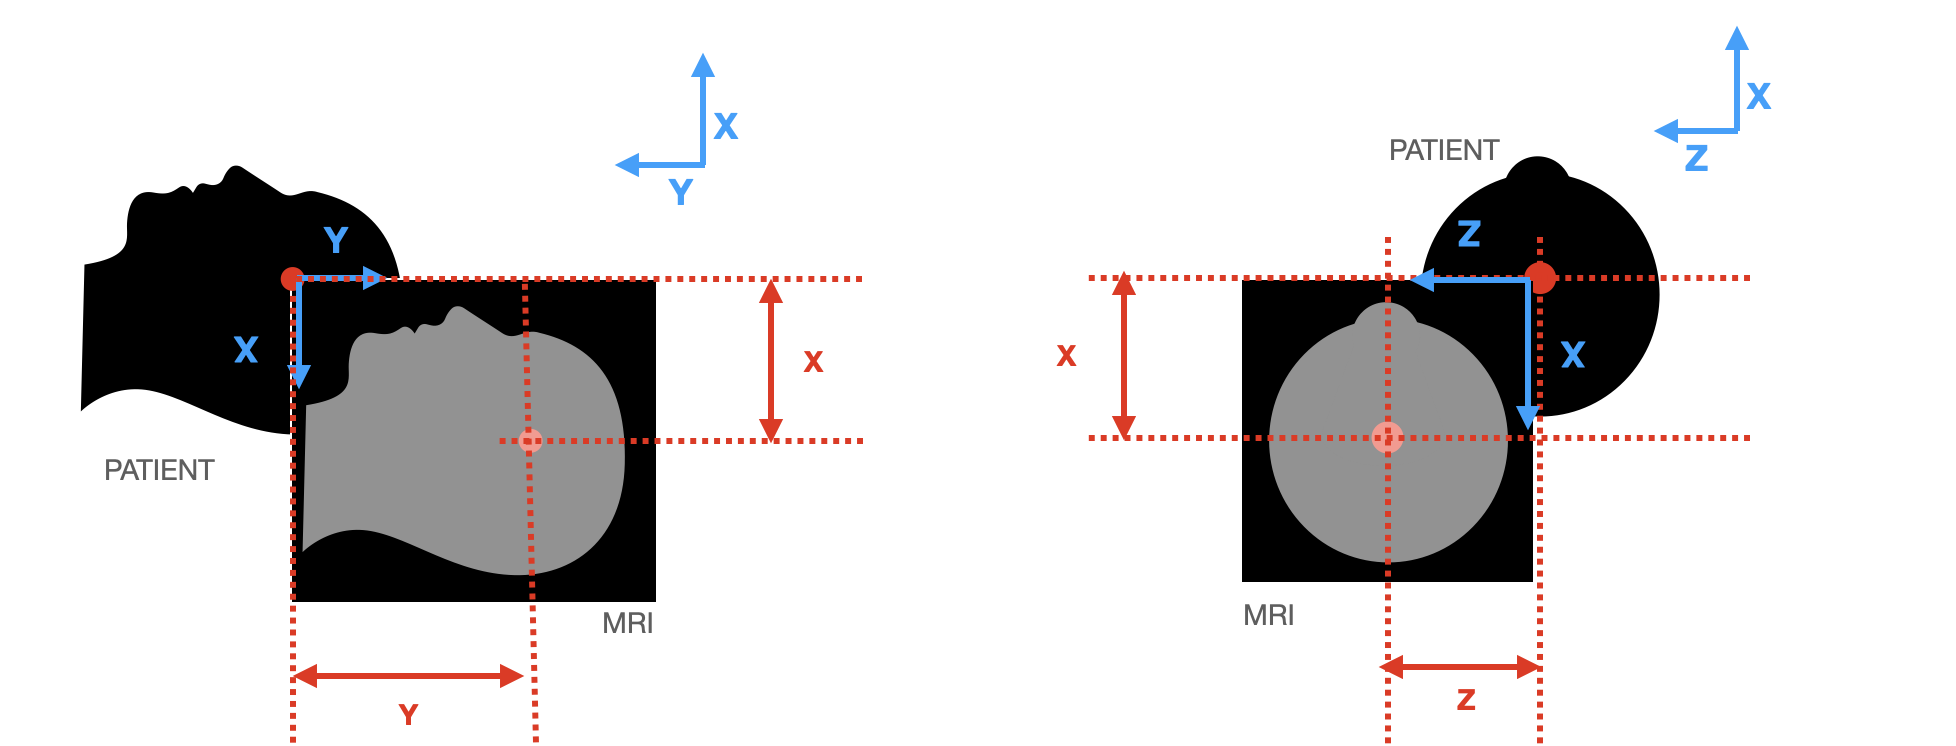

In [123]:
Image(filename="endosim_demo/images/3D_to_cam.png")

In [124]:
# Average head dimensions from: https://en.wikipedia.org/wiki/Human_head

x_t = 100 # head length (about 20cm)
y_t = 130 # menton to top of head (about 25cm)
z_t = 80 # head bredth (about 15cm)

PatRef_T_MRI = create_transform([-x_t, -y_t, -z_t, 0, 0, 0])
print("Cam_T_PntRef=\n" + str(PatRef_T_MRI))

Cam_T_PntRef=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


In [125]:
# These are the baseline parameters for the MRI registration (whether thats PBR or SBR)
PatRef_T_MRI_parameters = extract_rigid_body_parameters(PatRef_T_MRI)
print("PatRef_T_MRI=\n" + str(PatRef_T_MRI))
print("PatRef_T_MRI_parameters=" + str(PatRef_T_MRI_parameters))

PatRef_T_MRI=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]
PatRef_T_MRI_parameters=[0.0, 0.0, 0.0, -100.0, -130.0, -80.0]


## Summary of some details

In [126]:
# Endoscope ref tracking
print("endoscope_markers_in_camera_space=\n" + str(endoscope_markers_in_camera_space))
print("endoscope_markers_in_marker_space=\n" + str(endoscope_markers_in_marker_space))

print('\n')
print("Cam_T_EndRef_r=\n" + str(Cam_T_EndRef_r))
print("Cam_T_EndRef_t=\n" + str(Cam_T_EndRef_t))
print("Cam_T_Endo_FRE=\n" + str(Cam_T_Endo_FRE))
print("Cam_T_EndRef=\n" + str(Cam_T_EndRef))

# Patient ref tracking
print('\n')
print("Patient ref model=\n" + str(pat_ref))
print("Patient ref model in camera space=\n" + str(pat_ref_in_camera_space_at_patient))
print("Cam_T_PatRef_r=\n" + str(Cam_T_PatRef_r))
print("Cam_T_PatRef_t=\n" + str(Cam_T_PatRef_t))
print("Cam_T_PatRef_FRE=\n" + str(Cam_T_PatRef_FRE))
print("Cam_T_PatRef=\n" + str(Cam_T_PatRef))

# MRI to PatRef transform and parameters
print('\n')
print("PatRef_T_MRI=\n" + str(PatRef_T_MRI))
print("PatRef_T_MRI_parameters=" + str(PatRef_T_MRI_parameters))


endoscope_markers_in_camera_space=
[[ 106.06601718  106.06601718 1000.        ]
 [ 141.42135624  141.42135624 1000.        ]
 [ 159.09902577  194.45436483 1000.        ]
 [ 219.20310217  183.84776311 1000.        ]]
endoscope_markers_in_marker_space=
[[  0.   0. 150.]
 [  0.   0. 200.]
 [  0.  25. 250.]
 [  0. -25. 285.]]


Cam_T_EndRef_r=
[[ 8.49167095e-16 -7.07106781e-01  7.07106781e-01]
 [-1.02657308e-15  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00 -1.32504145e-15 -1.91457875e-18]]
Cam_T_EndRef_t=
[[-5.68434189e-14]
 [ 2.84217094e-14]
 [ 1.00000000e+03]]
Cam_T_Endo_FRE=
3.6230712748823524e-14
Cam_T_EndRef=
[[ 8.49167095e-16 -7.07106781e-01  7.07106781e-01 -5.68434189e-14]
 [-1.02657308e-15  7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.00000000e+00 -1.32504145e-15 -1.91457875e-18  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Patient ref model=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     

## Endoscope specific parameters

Previously the length of the pointer was specified in the variable: pointer_length, typically about 100mm.

We need a function to create a hand-eye transformation, between the tracking marker on the laparoscope, and the camera coordinate system.

In [127]:
#length_of_endoscope = 300

hand_eye = get_ref_T_tip(length_of_endoscope, 'z')
hand_eye

#end_ref_transformed = multiply_points_by_matrix(hand_eye, end_ref, do_transpose=True) # transform all pointer points by this reference
#end_ref_with_tip = np.concatenate((end_ref_transformed, [[0, 0, 0, 1]]), axis=0) # adding tip to points


array([[  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   1., 150.],
       [  0.,   0.,   0.,   1.]])

## Target Point in Camera and MRI space -------- point of debugging ---- transforms not going back to what it was

Imagine that the working distance of the endoscope is about 5cm. Then we need to know the location of the target point in camera, and world space.

In [128]:
target_location_in_camera_space = np.zeros((4,1))
target_location_in_camera_space[2][0] = 50
target_location_in_camera_space[3][0] = 1000

 
target_location_in_mri_space = camera_to_mri(np.linalg.inv(PatRef_T_MRI), np.linalg.inv(Cam_T_PatRef), Cam_T_EndRef, np.linalg.inv(hand_eye), target_location_in_camera_space)

print("Target in camera space=" + str(target_location_in_camera_space))
print("Target in MRI space= \n" + str(target_location_in_mri_space))

Target in camera space=[[   0.]
 [   0.]
 [  50.]
 [1000.]]
Target in MRI space= 
[[-130.        ]
 [  21.21320344]
 [-120.2081528 ]
 [   1.        ]]


In [129]:
target_location_in_mri_space = camera_to_mri(np.linalg.inv(PatRef_T_MRI), np.linalg.inv(Cam_T_PatRef), Cam_T_EndRef, np.linalg.inv(hand_eye), target_location_in_camera_space)
target_location_in_mri_space

array([[-130.        ],
       [  21.21320344],
       [-120.2081528 ],
       [   1.        ]])

In [130]:
back_in_cam = mri_to_camera(np.linalg.inv(PatRef_T_MRI), np.linalg.inv(Cam_T_PatRef), Cam_T_EndRef, np.linalg.inv(hand_eye), target_location_in_mri_space)
back_in_cam

array([[-2.84217094e-14],
       [ 0.00000000e+00],
       [-2.50000000e+02],
       [ 1.00000000e+00]])

In [131]:
print(target_location_in_camera_space)
T = np.linalg.inv(PatRef_T_MRI) @ np.linalg.inv(Cam_T_PatRef) @ Cam_T_EndRef @ np.linalg.inv(hand_eye) 
pnt_mri = multiply_point_by_matrix(T , target_location_in_camera_space)
pnt_mri

[[   0.]
 [   0.]
 [  50.]
 [1000.]]


array([[170.71067812],
       [130.        ],
       [ 59.28932188],
       [  1.        ]])

In [132]:
target_location_in_cam_space = mri_to_camera(np.linalg.inv(PatRef_T_MRI), np.linalg.inv(Cam_T_PatRef), Cam_T_EndRef, np.linalg.inv(hand_eye),target_location_in_mri_space)
target_location_in_cam_space

array([[-2.84217094e-14],
       [ 0.00000000e+00],
       [-2.50000000e+02],
       [ 1.00000000e+00]])

Now that we have an endoscope system set up. Let's simulate what the effect of tracker noise is on 3D and 2D overlay accuracy, and also registration errors (mm/degrees), on both 3D and 2D overlay accuracy. 

# Simulation 1: Effect of Tracker Noise on Endoscope System

Similar to in the pointer simulation, here we add random noise to the location of the tracking markers (pointer and patient ref) and see how far the endoscope's tip position moves relative to the tumour.

### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 0.5, in steps of 0.05
*   for iteration in 1 to 10,000.
*     add zero mean Gaussian(sigma) noise to each tracking marker. 
*     recompute transforms.
*     recompute position of target point
*     measure Euclidean distance in MRI space
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma

In [133]:
transformed_point = camera_to_mri( np.linalg.inv(PatRef_T_MRI), np.linalg.inv(Cam_T_PatRef), Cam_T_EndRef, hand_eye, target_location_in_camera_space)


In [134]:
transformed_point

array([[-130.        ],
       [ 233.34523779],
       [  91.92388155],
       [   1.        ]])

tracking error at 0.12 is [299.9572086]mm
tracking error at 0.15 is [299.98004397]mm
tracking error at 0.25 is [300.39775732]mm


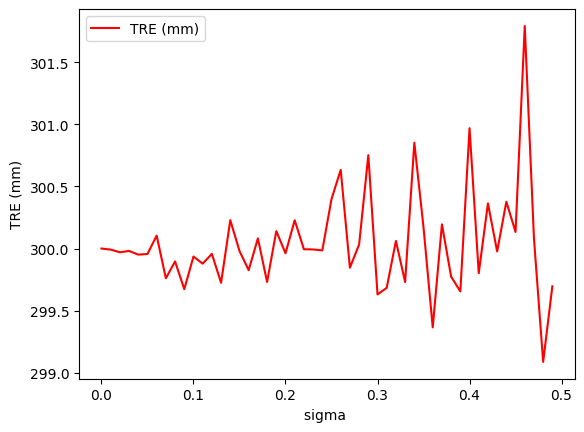

In [135]:
x_values = []
y_values = []

number_samples = 10
for sigma_counter in range(0, 50, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the endoscope and reference in camera space
        tmp_endoscope_markers_in_camera_space = add_noise_to_points(endoscope_markers_in_camera_space, sigma) # Mustn't include pointer tip! 
        tmp_pat_ref_in_camera_space_at_patient = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], sigma)

        # recompute transforms with the noisy reference points (from references to camera)
        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope_markers_in_camera_space, endoscope_markers_in_marker_space)
        noisy_Cam_T_EndRef = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_pat_ref_in_camera_space_at_patient, pat_ref[0:4, 0:3])
        noisy_Cam_T_PatRef = mu.construct_rigid_transformation(R, t)
        


        # use noisy transforms to get a target location from camera space to MRI space.
        transformed_point = camera_to_mri( np.linalg.inv(PatRef_T_MRI), np.linalg.inv(noisy_Cam_T_PatRef), noisy_Cam_T_EndRef, hand_eye, target_location_in_camera_space)
        #print(transformed_point)
        euclid_dist = calculate_euclid_dist(transformed_point, target_location_in_mri_space)
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25:
        tracker_25 = rms
        print(f'tracking error at {sigma} is {tracker_25}mm')
    if sigma == 0.12:
        tracker_12 = rms
        print(f'tracking error at {sigma} is {tracker_12}mm')
    if sigma == 0.15:
        tracker_15 = rms
        print(f'tracking error at {sigma} is {tracker_15}mm')
            
        
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma ')
plt.ylabel('TRE (mm)')
plt.show()
        

# Simulation 2: Tracking error + Registration error for Endoscope System

As above, we'd like to simulate the effects of registration error, as well as tracking error similar to the pointer simulation:

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 0.5, in steps of 0.01
*   for iteration in 1 to 1000.
*     add zero mean Gaussian (sigma) noise to each tracking marker for EndRef and PatRef. 
*     add zero mean Gaussian (sigma) noise to each parameter of the PatRef_T_MRI transform
*     recompute transforms.
*     recompute position of target point using noisy transforms
*     measure Euclidean distance in MRI space
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

tracking + registration error at 0.12 is [415.80179517]mm
tracking + registration error at 0.15 is [415.97468878]mm
tracking + registration error at 0.25 is [416.0848523]mm


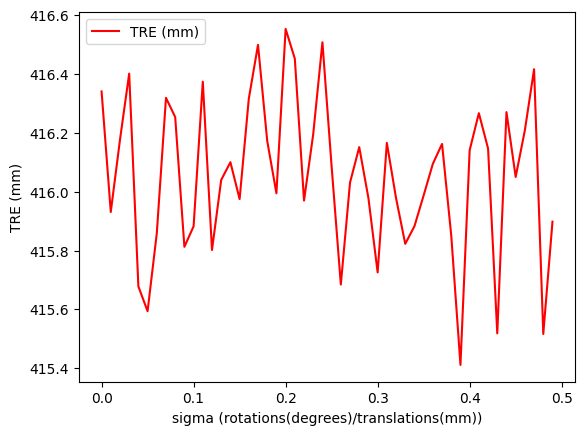

In [136]:
x_values = []
y_values = []
for sigma_counter in range(0, 50, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the endoscope and and patient reference in cam space
        tmp_endoscope = add_noise_to_points(endoscope_markers_in_camera_space, typical_tracking_sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], typical_tracking_sigma)
        
        # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
        tmp_params = add_noise_to_params(PatRef_T_MRI_parameters, sigma)
        tmp_mri_to_patref = rigid_body_parameters_to_matrix(tmp_params)
        
        # recompute transforms with noisy markers
        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope, endoscope_markers_in_marker_space)
        tmp_endoscope_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        # transform target point to MRI space using noisy transforms and calculate euclid dist between that and original point.
        transformed_point = camera_to_mri(tmp_endoscope_to_cam, tmp_reference_to_cam, tmp_mri_to_patref, hand_eye, target_location_in_camera_space)
        euclid_dist =  calculate_euclid_dist(transformed_point, target_location_in_mri_space)
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25:
        tracking_reg_25 = rms
        print(f'tracking + registration error at {sigma} is {tracking_reg_25}mm')
    if sigma == 0.12:
        tracking_reg_12 = rms
        print(f'tracking + registration error at {sigma} is {tracking_reg_12}mm')
    if sigma == 0.15:
        tracking_reg_15 = rms
        print(f'tracking + registration error at {sigma} is {tracking_reg_15}mm')
                    
        
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('TRE (mm)')
plt.show()
     

# Simulation 3: Effect of Hand-Eye and Tracking Error in Endoscope System

In addition to above, what if we vary hand-eye, is this better/worse, meaning less/more important to get right than the registration?

The problem with this experiment, is we don't yet know how variable a typical hand-eye calibration is. Imagine the scenario where 10 different members of staff did 10 different calibrations and we looked at the standard-deviation (sigma) of the rotation parameters, and translation parameters. If the rotation and translation parameters' standard deviations were much worse than 0-1, then the numbers below would need adjusting.

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 0.5, in steps of 0.05
*   for iteration in 1 to 10,000.
*     add zero mean Gaussian (sigma) noise to each tracking marker for EndRef and PatRef. 
*     add zero mean Gaussian (sigma) noise to each parameter of the hand-eye transform 
*     recompute transforms.
*     recompute position of target point using noisy transforms
*     measure Euclidean distance in MRI space
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

In [137]:
# NOTE TO MENTION- ISN'T THIS THE SAME AS OFFSET FUNCTION?
def create_hand_eye(length_of_endoscope):
    transform = np.eye(4)
    transform[2][3] = -(100 - length_of_endoscope)
    return transform

In [138]:
hand_eye

array([[  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   1., 150.],
       [  0.,   0.,   0.,   1.]])

hand-eye tracking error at sigma 0.12 is [415.93914751]
hand-eye tracking error at sigma 0.15 is [416.20280686]
hand-eye tracking error at sigma 0.25 is [415.96537976]


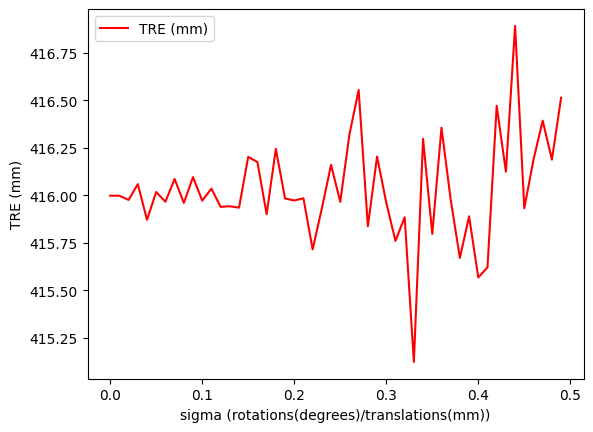

In [139]:
Hand_T_Eye_parameters = extract_rigid_body_parameters(hand_eye)


x_values = []
y_values = []
for sigma_counter in range(0, 50, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the pointer and reference.
        tmp_endoscope = add_noise_to_points(endoscope_markers_in_camera_space, sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], sigma)
        
        # Here we add noise onto the Hand_T_Eye_parameters, and reconstruct a new registration
        tmp_hand_eye_params = add_noise_to_params(Hand_T_Eye_parameters, sigma)
        tmp_hand_eye = rigid_body_parameters_to_matrix(tmp_hand_eye_params)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope, endoscope_markers_in_marker_space)
        tmp_endoscope_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        transformed_point = camera_to_mri(tmp_endoscope_to_cam, tmp_reference_to_cam, PatRef_T_MRI, tmp_hand_eye, target_location_in_camera_space)
        
        euclid_dist = calculate_euclid_dist(transformed_point, target_location_in_mri_space)
        
        rms = rms + euclid_dist
    
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25:
        hand_eye_25 = rms
        print(f'hand-eye tracking error at sigma {sigma} is {hand_eye_25}')
    if sigma == 0.12:
        hand_eye_12 = rms
        print(f'hand-eye tracking error at sigma {sigma} is {hand_eye_12}')
    if sigma == 0.15:
        hand_eye_15 = rms
        print(f'hand-eye tracking error at sigma {sigma} is {hand_eye_15}')
           
        
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('TRE (mm)')
plt.show()
     

# Simulation 4: In AR How Many Pixels Off?

The above simulations simply measure the true 3D distance in MRI space. That is, given tracking errors, and either hand-eye or registration errors, how far off would we be if we mapped back to MRI space. (Similarly we could run the application the other way round, and express this in camera space, but the error would be the same).

However, given that the field of view is so, small, how many pixels would this amount to? Most endoscopes run on 1920x1080p Full HD, on a reasonable monitor. So, how many pixels off are we?

In the simulation below, we will assume we are dealing with a perfect hand-eye calibration, and repeat the experiment that investigated errors in registration, but this time projecting to the image coordinates and measuring the distance in pixels. If subsequent lab experiments show that hand-eye is more critical, then the experiment below can be repeated, but varying the hand-eye instead of the registration.

First we project our 3D target points to 2D using the intrinsics and distortion matrices that we got during calibration of the endoscope.

In [140]:
# Camera calibration
intrinsics = np.loadtxt('endosim_demo/calibration/intrinsics.txt')
distortion = np.loadtxt('endosim_demo/calibration/distortion.txt')

print("Intrinsics are:" + str(intrinsics))
print("Distortion coefficients are:" + str(distortion))

# Need to project target point to image plane. Incidentally, the target point 
# was straight along the optical axis, so should project to the middle of the image.
target_location_in_image_coordinates = project_camera_point_to_image(target_location_in_camera_space, intrinsics, distortion)
print("target_location_in_image_coordinates=" + str(target_location_in_image_coordinates))

Intrinsics are:[[664.6329766    0.         931.53151205]
 [  0.         663.83211807 520.64004697]
 [  0.           0.           1.        ]]
Distortion coefficients are:[-4.0929449e-01  2.1631278e-01  1.1120000e-05  1.2712000e-03
 -7.2057120e-02]
target_location_in_image_coordinates=[931.53151205 520.64004697]


```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 0.5, in steps of 0.05
*   for iteration in 1 to 10,000.
*     add zero mean Gaussian (sigma) noise to each tracking marker for EndRef and PatRef. 
*     add zero mean Gaussian (sigma) noise to each parameter of the PatRef_T_MRI transform
*     add zero mean Gaussian (sigma) noise to each parameter of the hand-eye transform
*     recompute transforms.
*     recompute position of target point using noisy transforms
*     project target point from camera to image space
*     measure Euclidean distance between target point and projected target point in image space 
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

number of pxls off at sigma 0.12 is 26693.712358198794
number of pxls off at sigma 0.15 is 25756.18354413351
number of pxls off at sigma 0.25 is 27449.692844471963


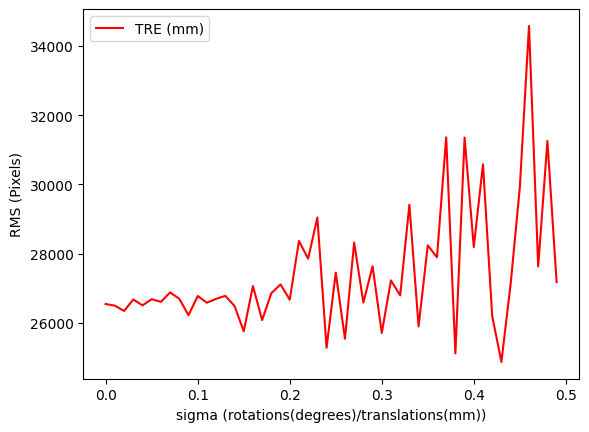

In [141]:

x_values = []
y_values = []
for sigma_counter in range(0, 50, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the pointer and reference, then reconstruct the transforms.
        tmp_endoscope = add_noise_to_points(endoscope_markers_in_camera_space, sigma) # Mustn't include pointer tip! 
        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope, endoscope_markers_in_marker_space)
        tmp_endoscope_to_cam = mu.construct_rigid_transformation(R, t)

        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], sigma)
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)

        # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
        tmp_params = add_noise_to_params(PatRef_T_MRI_parameters, sigma)
        tmp_mri_to_patref = rigid_body_parameters_to_matrix(tmp_params)
        
        # adding noise to hand-eye
        tmp_hand_eye_params = add_noise_to_params(Hand_T_Eye_parameters, sigma)
        tmp_hand_eye = rigid_body_parameters_to_matrix(tmp_hand_eye_params)
        

        
        # convert noisy target oint from MRI space to camera space
        transformed_point_in_camera_space = mri_to_camera(tmp_endoscope_to_cam, tmp_reference_to_cam, tmp_mri_to_patref, tmp_hand_eye, target_location_in_mri_space)
        # project noisy target point from camera space to image space
        transformed_point_in_image_space = project_camera_point_to_image(transformed_point_in_camera_space, intrinsics, distortion)
        
        # compute euclidean distance between true target point and noisy in image space
        euclid_dist =  (transformed_point_in_image_space[0] - target_location_in_image_coordinates[0]) \
                     * (transformed_point_in_image_space[0] - target_location_in_image_coordinates[0]) \
                     + (transformed_point_in_image_space[1] - target_location_in_image_coordinates[1]) \
                     * (transformed_point_in_image_space[1] - target_location_in_image_coordinates[1]) 
        
        rms = rms + euclid_dist
    
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25:
        AR_pxls_25 = rms
        print(f'number of pxls off at sigma {sigma} is {AR_pxls_25}')
    if sigma == 0.12:
        AR_pxls_12 = rms
        print(f'number of pxls off at sigma {sigma} is {AR_pxls_12}')
    if sigma == 0.15:
        AR_pxls_15 = rms
        print(f'number of pxls off at sigma {sigma} is {AR_pxls_15}')
        
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (Pixels)')
plt.show()


# Summary of Model 2

It's interesting to compare 3D errors, and the subsequent effect in pixels in 2D. 

If we have an endoscope of length:

In [142]:
print(length_of_endoscope)

150


### Tracking error

From Simulation 1, we can see that with an NDI Polaris Spectra that has a sigma of 0.25, we would expect to get the following TREs

In [143]:
tracker_25[0]

300.39775732430377

Furthermore, if we upgraded to the latest Veiga, which has a sigma of about 0.12, we might achieve TREs of:

In [144]:
tracker_15[0]

299.98004396614004

In [145]:
print(f'sigma 12 tracking error: {tracker_12[0]}')
print(f'sigma 15 tracking error: {tracker_15[0]}')
print(f'sigma 25 tracking error: {tracker_25[0]}')

sigma 12 tracking error: 299.9572086024864
sigma 15 tracking error: 299.98004396614004
sigma 25 tracking error: 300.39775732430377


### Tracking + registration

In Simulation 2, and assuming from the literature that rotational errors and translational errors of surface based registration are 0.5-1.0 mm/degrees, then we might expect TRE errors of about: 

In [146]:
print(f'sigma 12: {tracking_reg_12[0]}')
print(f'sigma 15: {tracking_reg_15[0]}')
print(f'sigma 25: {tracking_reg_25[0]}')

sigma 12: 415.8017951653116
sigma 15: 415.9746887787724
sigma 25: 416.0848523014271


### Hand-eye

In simulation 3, we can see that with an NDI Polaris Spectra that has a sigma of 0.25, and simulating Hand-Eye calibration errors with sigma 0-1 for rotational and translational parameters, we see that if errors are in the 0.5-1.0mm/degrees level, then we might expect TRE errors of about: 

In [147]:
print(f'sigma 12: {hand_eye_12[0]}')
print(f'sigma 15: {hand_eye_15[0]}')
print(f'sigma 25: {hand_eye_25[0]}')

sigma 12: 415.9391475084729
sigma 15: 416.20280685623516
sigma 25: 415.96537976169225


### AR error

Finally simulation 4 shows us that given a perfect hand-eye, and if we again use a sigma of 0.5-1.0 mm/degrees for the registration performance, and a 'typical' level of noise on tracking markers (e.g. like Simulation 2), that TRE of around 3-6mm would map an error in pixels of 

In [148]:
print(f'sigma 12: {AR_pxls_12}')
print(f'sigma 15: {AR_pxls_15}')
print(f'sigma 25: {AR_pxls_25}')

sigma 12: 26693.712358198794
sigma 15: 25756.18354413351
sigma 25: 27449.692844471963


Given that a modern endoscope is 1920x1080, (full HD), then we would expect errors:

In [149]:
print(f'between {round(AR_pxls_12/1920*100,1)}% and {round(AR_pxls_25/1920*100,1)}% in screen width')
print(f'between {round(AR_pxls_12/1080*100,1)}% and {round(AR_pxls_25/1080*100,1)}% in screen height')

between 1390.3% and 1429.7% in screen width
between 2471.6% and 2541.6% in screen height


# Saving results in CSV file

In [153]:

header = ['error', 'sigma_12', 'sigma_15', 'sigma_25']

data_endoscope = [
    ['tracking', tracker_12, tracker_15, tracker_25],
    ['tracking_registration', tracking_reg_12, tracking_reg_15, tracking_reg_25],
    ['hand_eye', hand_eye_12, hand_eye_15, hand_eye_25],
    ['AR_px', AR_pxls_12, AR_pxls_15, AR_pxls_25],
]

with open('results/endoscope.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    # Use writerows() not writerow()
    writer.writerows(data_endoscope)


From Simulation 3, we can see that with an NDI Polaris Spectra that has a sigma of 0.25, we would expect to get the following TREs of about 1.5mm. Furthermore, if we upgraded to the latest Veiga, which has a sigma of about 0.12, we might achieve TREs around 0.5mm. 

In Simulation 4, and assuming from the literature that rotational errors and translational errors of surface based registration are 0.5-1.0 mm/degrees, then we might expect TRE errors of about 3-6mm. (TODO: Can we do a surface based registration experiment ourselves?)

In simulation 5, we can see that with an NDI Polaris Spectra that has a sigma of 0.25, and simulating Hand-Eye calibration errors with sigma 0-1 for rotational and translational parameters, we see that if errors are in the 0.5-1.0mm/degrees level, then we might expect TRE errors of about 2.75-4.0mm.

Simulation 6 shows us that given a perfect hand-eye, and if we again use a sigma of 0.5-1.0 mm/degrees for the registration performance, and a 'typical' level of noise on tracking markers (e.g. like Simulation 4), that TRE of around 3-6mm would map to 80 - 140 pixels. Given that a modern endoscope is 1920x1080, (full HD), then we would expect errors between 4-7% of the screen width and 7-13%& in height, which will look pretty terrible.


In [151]:
# NOTE TO MENTION- ISN'T THIS THE SAME AS OFFSET FUNCTION?
def create_hand_eye(length_of_endoscope):
    transform = np.eye(4)
    transform[2][3] = -(100 - length_of_endoscope)
    return transform

The tracking ball nearest the tip has a +ve z coordinate of 100 ((((to double check with matt)))))). 

If we move towards the pointer/laparoscope tip, you'd expect the z-coordinate to decrease. 

Furthermore, if we imagine that the laparoscope is 30cm/300mm long, then a point that is 300mm from the tracking ball would have z-coordinate -200. 

So, if we multiple [0, 0, -200] by hand-eye (i.e. the marker-to-camera transformation, we would expect the [0, 0, -200] to be mapped to [0, 0, 0], i.e the centre of projection of the laparoscope. 

In [152]:
length_of_endoscope = 300

cop_in_laparascope_marker_space=np.zeros((4,1))
cop_in_laparascope_marker_space[2][0] = -200
cop_in_laparascope_marker_space[3][0] = 1

print("Input=" + str(cop_in_laparascope_marker_space))

#hand_eye = create_hand_eye(length_of_endoscope)
print("Transform=" + str(hand_eye))

cop_in_camera_space = multiply_point_by_matrix(hand_eye, cop_in_laparascope_marker_space)
print("Output=" + str(cop_in_camera_space))


Input=[[   0.]
 [   0.]
 [-200.]
 [   1.]]
Transform=[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 150.]
 [  0.   0.   0.   1.]]
Output=[[  0.]
 [  0.]
 [-50.]
 [  1.]]
